In [5]:
import kagglehub
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random

# Descargar el dataset
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")
print("Path to dataset files:", path)

# Ruta al archivo meta.csv
meta_csv = os.path.join(path, "Meta.csv")  # Ajusta si el nombre es diferente
data_dir = path

# Dataset personalizado
class TrafficSignsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Cargar imagen y etiqueta
        img_name = os.path.join(self.root_dir, self.data.iloc[idx]['Path'])
        image = Image.open(img_name).convert('RGB')
        label = int(self.data.iloc[idx]['ClassId'])

        if self.transform:
            image = self.transform(image)

        return image, label

# Transformaciones con redimensionamiento
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionar imágenes a 128x128
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Crear datasets y loaders nuevamente
train_dataset = TrafficSignsDataset(csv_file=meta_csv, root_dir=data_dir, transform=transform)
test_dataset = TrafficSignsDataset(csv_file=meta_csv, root_dir=data_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Modelo red neurnal
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2)  # Salida: 16x128x128
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)       # Reduce a la mitad
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2) # Salida: 32x64x64
        # Pool nuevamente: 32x32x32
        self.fc1 = nn.Linear(32 * 32 * 32, 280)  # Dimensiones ajustadas manualmente
        self.fc2 = nn.Linear(280, num_classes)   # Salida igual al número de clases

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))     # Primera convolución y pooling
        x = self.pool(F.relu(self.conv2(x)))     # Segunda convolución y pooling
        x = x.view(x.size(0), -1)                # Aplanar el tensor
        x = F.relu(self.fc1(x))                  # Primera capa totalmente conectada
        x = self.fc2(x)                          # Salida
        return x

# Número de clases dinámico
df = pd.read_csv(meta_csv)
num_classes = len(df['ClassId'].unique())

# Crear el modelo
model = ConvNet(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento
epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

# Evaluación en el conjunto de prueba
correct = 0
total = 0
model.eval()  # Cambiamos a modo evaluación
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the test set: {accuracy}%')


Path to dataset files: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1
Epoch 1, Loss: 3.7608256340026855
Epoch 2, Loss: 3.4183712005615234
Epoch 3, Loss: 2.6457178592681885
Epoch 4, Loss: 1.9667575359344482
Epoch 5, Loss: 1.4562056064605713
Accuracy of the model on the test set: 83.72093023255815%


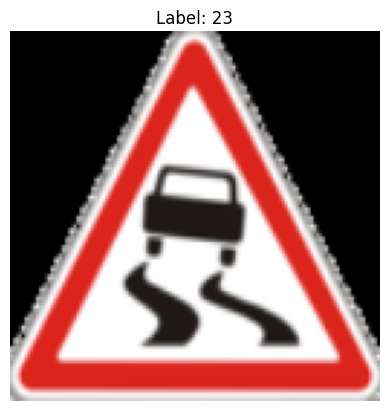

In [8]:
import matplotlib.pyplot as plt
import random

# Selecciona un índice aleatorio
random_idx = random.randint(0, len(test_dataset) - 1)

# Obtén la imagen y la etiqueta correspondiente
image, label = test_dataset[random_idx]

# Desnormaliza la imagen para visualizarla correctamente

image = image * 0.5 + 0.5  # Invertir la normalización (Normalize((0.5,), (0.5,)))

# Mostrar la imagen con matplotlib
plt.imshow(image.permute(1, 2, 0))  # Cambiar las dimensiones de (C, H, W) a (H, W, C)
plt.title(f"Label: {label}")
plt.axis('off')  # Quitar los ejes
plt.show()

